### Analyze the influence processes of musical evolution that occurred over time in one genre. Can your team identify indicators that reveal the dynamic influencers, and explain how the genre(s) or artist(s) changed over time?

In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import math

In [3]:
artists = pd.read_csv('data_by_artist.csv')
artists = artists.drop_duplicates(subset='artist_name', keep='last')
years = pd.read_csv('data_by_year.csv')
influence = pd.read_csv('influence_data.csv')

In [4]:
from tqdm import tqdm
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in tqdm(range(len(full))): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')

artistGenres = {} #adds song genre to full
for i in tqdm(range(len(influence))):
    row = influence.iloc[i]
    influencer = row['influencer_id']
    follower = row['follower_id']
    infGenre = row['influencer_main_genre']
    folGenre = row['follower_main_genre']
    artistGenres[influencer] = infGenre
    artistGenres[follower] = folGenre

def getGenre(row):
    artist = row['artists_id']
    if type(artist) == list:
        print(row)
    try:
        genre = artistGenres[artist]
    except KeyError:
        genre = 'N/A'
    return genre

full['genre'] = full.apply(lambda row: getGenre(row), axis = 1)

full.head()


  0%|                                                                                        | 0/98340 [00:00<?, ?it/s]C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.0672,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,Electronic
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.0136,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,Electronic
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.0156,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,Electronic
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.1080,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.2760,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;


In [5]:
# list artist names
names = []
for i in artists['artist_name']:
    names.append(i)
    
# refine influence df
influence = influence[influence['influencer_name'].isin(names)]
influence = influence[influence['follower_name'].isin(names)]
influence = influence.reset_index(drop=True)
influence.head()

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990


In [13]:
idDict = {}
for i in range(len(artists)):
    try:
        idDict[artists['artist_id'][i]] = artists['artist_name'][i]
    except:
        pass

iGraph = nx.DiGraph()
for artist in artists['artist_id']:
    iGraph.add_node(artist, weight = 0)
    
for i in range(len(influence)):
    influencer = influence["influencer_id"][i]
    follower = influence['follower_id'][i]
    
    iGraph.add_edge(influencer,follower)    

arts = []
artnames = []
scores = []
for node in iGraph.nodes():
    children = list(iGraph.successors(node))
    total = 0
    for child in children:
        total += iGraph.out_degree[child]
        
    iGraph.nodes[node]['weight'] = total
    arts.append(node)
    try:
        artnames.append(idDict[node])
    except KeyError:
        artnames.append('Unknown')
    scores.append(total)
    
   
totalInfluence = pd.DataFrame({'names':artnames, 'artists':arts, 'scores':scores})
totalInfluence = totalInfluence.sort_values(by=['scores'], ascending = False)
totalInfluence = totalInfluence.reset_index(drop=True)
totalInfluence

,names,artists,scores
0,The Beatles,754032,11223
1,Bob Dylan,66915,7923
2,The Rolling Stones,894465,6337
3,Chuck Berry,120521,5893
4,Elvis Presley,180228,4743
...,...,...,...
5847,Joss Stone,286572,0
5848,She Wants Revenge,328201,0
5849,Jonathan Coulton,329542,0
5850,No Use for a Name,344037,0


In [6]:
# list genres
genre = []
for i in influence['influencer_main_genre']:
    if i not in genre:
        genre.append(i)
for i in influence['follower_main_genre']:
    if i not in genre:
        genre.append(i)

In [7]:
# dict of genres paired w their artists
artistByGenre = {}
for i in genre:
    artistByGenre[i] = []
i = 0
while i < len(influence):
    genreList = artistByGenre.get(influence['influencer_main_genre'][i])
    genreListF = artistByGenre.get(influence['follower_main_genre'][i])
    if influence['influencer_name'][i] not in genreList:
        genreList.append(influence['influencer_name'][i])
    if influence['follower_name'][i] not in genreListF:
        genreListF.append(influence['follower_name'][i])
    i += 1

In [159]:
#all Pop/Rock songs and a list of Pop/Rock artists
prSongs = full[full['genre'] == 'Pop/Rock']
prSongs = prSongs.sort_values(by=['popularity'])
prSongs = prSongs.reset_index(drop=True)
prSongs['mood'] = prSongs['danceability'] + prSongs['valence']
prSongs = prSongs.sort_values(by=['popularity'], ascending=False)
prArtists = list(set(list(prSongs['artist_names'])))
prSongs

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,...,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre,mood
48518,Ariana Grande,2264745,0.672,0.855,0.646,0.504140,-3.764,1,9,0.0210,...,0.3230,0.0397,0,182200,94,2020,5/22/2020,Rain On Me (with ****** Grande),Pop/Rock,1.318
48517,Justin Bieber,2165952,0.597,0.450,0.537,0.732370,-6.658,1,8,0.2230,...,0.3820,0.0418,0,228482,94,2020,5/8/2020,Stuck with U (with Justin Bieber),Pop/Rock,1.134
48516,Ariana Grande,2264745,0.597,0.450,0.537,0.732370,-6.658,1,8,0.2230,...,0.3820,0.0418,0,228482,94,2020,5/8/2020,Stuck with U (with Justin Bieber),Pop/Rock,1.134
48515,Lady Gaga,994823,0.672,0.855,0.646,0.504140,-3.764,1,9,0.0210,...,0.3230,0.0397,0,182200,94,2020,5/22/2020,Rain On Me (with ****** Grande),Pop/Rock,1.318
48514,Dua Lipa,3426731,0.794,0.793,0.677,0.507766,-4.521,0,11,0.0125,...,0.0952,0.0842,0,183290,93,2019,10/31/2019,Don't Start Now,Pop/Rock,1.471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,Mina,492521,0.458,0.554,0.649,0.647300,-11.206,1,7,0.6600,...,0.2420,0.0413,0,132545,0,1942,11/13/1942,Renato,Pop/Rock,1.107
36,Demi Lovato,996127,0.713,0.916,0.669,0.393280,-3.310,1,0,0.0370,...,0.0681,0.0401,0,175320,0,2020,6/5/2020,Échame La Culpa,Pop/Rock,1.382
35,Mina,492521,0.619,0.320,0.701,0.479313,-12.270,0,0,0.6740,...,0.3530,0.0413,0,159112,0,1942,11/13/1942,Sabato notte,Pop/Rock,1.320
34,Robert Palmer,93632,0.440,0.443,0.522,0.409044,-20.145,1,0,0.9870,...,0.8390,0.0469,0,127933,0,1945,1945,Toccata ostinato,Pop/Rock,0.962


In [183]:
#Calculate mood least squares diffrential from mean of all Pop/Rock songs every year
def PRDiffRank(name):
    prMeans = prSongs.groupby(['year']).mean()
    prMeans = prMeans.reset_index()
    prMeans = prMeans[prMeans['year'] > 1947]
    ns = prSongs[prSongs['artist_names'] == name]
    ns = ns.groupby(['year']).mean()
    ns = ns.reset_index()
    diff = 0
    prMeans = prMeans[prMeans['year'].isin(list(ns['year']))]
    prMeans = prMeans.reset_index(drop=True)
    for count, val in enumerate(prMeans['mood']):
        diff += (val - ns['mood'][count]) ** 2
    return diff
        
    

In [184]:
#PRDiffRank with visualization
def importancetoPR(name):
    prMeans = prSongs.groupby(['year']).mean()
    prMeans = prMeans.reset_index()
    prMeans = prMeans[prMeans['year'] > 1947]
    ns = prSongs[prSongs['artist_names'] == name]
    ns = ns.groupby(['year']).mean()
    ns = ns.reset_index()
    year = prMeans['year']
    attribute = prMeans['mood']
    nmood = ns['mood']
    nyear = ns['year']
    plt.plot(year, attribute, 'ro')
    plt.plot(nyear, nmood, 'bo')
    plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 5))(np.unique(year)), '-r', label='All Pop/Rock')
    plt.plot(np.unique(nyear), np.poly1d(np.polyfit(nyear, nmood, 5))(np.unique(nyear)), '-b', label = name)
    plt.ylabel('Mood')
    plt.xlabel('Year')
    plt.legend()
    diff = 0
    prMeans = prMeans[prMeans['year'].isin(list(ns['year']))]
    prMeans = prMeans.reset_index(drop=True)
    for count, val in enumerate(prMeans['mood']):
        diff += (val - ns['mood'][count]) ** 2
    return diff

In [185]:
#Pop/Rock artists sorted by ascending diffrential
prArtistsDF = artists[artists['artist_name'].isin(prArtists)]
prArtistsDF['Diffrential'] = prArtistsDF['artist_name'].apply(PRDiffRank)
prArtistsDF = prArtistsDF.sort_values(by=['Diffrential'])
prArtistsDF = prArtistsDF.reset_index(drop=True)
prArtistsDF = prArtistsDF[prArtistsDF['Diffrential'] > 0]
prArtistsDF

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count,Diffrential
3,The Postal Service,894962,0.628278,0.680889,0.356517,139.299167,-7.395111,1,0,0.128200,0.165626,0.136206,0.042761,268931.1667,44.166667,36,9.665768e-08
4,Elbow,134051,0.478000,0.715000,0.505500,125.672000,-5.585500,1,2,0.255000,0.000001,0.353500,0.027850,306813.0000,44.500000,4,4.947678e-07
5,The Clientele,62609,0.479000,0.329000,0.549000,102.704000,-12.219000,1,10,0.769000,0.199000,0.102000,0.025800,204387.0000,40.000000,2,1.254338e-06
6,The Von Bondies,923208,0.491000,0.966000,0.480000,147.836000,-3.896000,1,5,0.078700,0.000000,0.281000,0.133000,133547.0000,53.000000,2,1.858528e-06
7,The Motors,405494,0.516000,0.451000,0.577000,136.601000,-11.828000,0,11,0.310000,0.000000,0.125000,0.028400,278933.0000,45.000000,2,1.935887e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,Chuck Berry,120521,0.627402,0.616434,0.809753,126.192406,-10.259329,1,0,0.683166,0.120010,0.192289,0.061202,157233.2922,29.721461,219,3.118486e+00
2739,Daryl Hall & John Oates,674887,0.680645,0.581857,0.790818,123.819995,-10.282719,1,5,0.273099,0.021960,0.125739,0.049845,240561.9310,37.098522,203,3.147359e+00
2740,Jimmy Buffett,350840,0.636127,0.462122,0.667419,122.427419,-13.360631,1,7,0.371229,0.009146,0.186968,0.043740,226808.9204,34.440318,377,3.529976e+00
2741,UB40,181376,0.777607,0.491888,0.866438,115.871213,-12.796461,1,2,0.082735,0.083506,0.106270,0.062949,244178.1685,45.685393,89,4.314920e+00


In [186]:
#Most influential of all Pop/Rock Artists
prLegends = []
for i in prArtistsDF['artist_name']:
        df = totalInfluence[totalInfluence['names'] == i]
        if len(df) > 0:
            index = df.index[0]
            if index < 0.01 * len(totalInfluence):
                prLegends.append(i) 
prLegendsDF = prArtistsDF[prArtistsDF['artist_name'].isin(prLegends)]
prLegendsDF = prLegendsDF.reset_index(drop=True)
prLegendsDF

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count,Diffrential
0,The Yardbirds,489303,0.480548,0.638417,0.647690,123.367083,-10.635988,1,0,0.213877,0.169364,0.181681,0.057213,170852.7500,27.404762,84,0.040316
1,The Velvet Underground,840402,0.484079,0.503375,0.554967,115.886429,-11.817983,1,2,0.340720,0.167388,0.193360,0.042714,264561.5989,35.920904,177,0.131393
2,Led Zeppelin,139026,0.421562,0.688843,0.505988,118.887166,-10.202317,1,2,0.223537,0.158421,0.226333,0.062070,327086.2959,41.417160,676,0.161795
3,Sex Pistols,418740,0.294263,0.939000,0.401316,144.990421,-5.915211,1,9,0.026918,0.039091,0.234321,0.107358,197452.5263,36.105263,38,0.206356
4,The Stooges,562304,0.385821,0.764436,0.450233,122.538410,-7.061026,1,2,0.010889,0.204486,0.227441,0.063141,266561.8205,35.333333,78,0.208217
5,MC5,182598,0.420368,0.771421,0.628158,125.009526,-8.078105,1,2,0.187765,0.059437,0.401511,0.063453,225523.3158,30.947368,38,0.278813
6,The Byrds,631774,0.469870,0.579786,0.662279,120.569389,-10.160832,1,2,0.334328,0.059134,0.239382,0.037782,167257.4122,27.984733,262,0.328977
7,Cream,112462,0.436184,0.560395,0.572026,124.187553,-13.135105,1,7,0.267302,0.115986,0.287992,0.044347,276187.1053,38.973684,76,0.344320
8,The Beatles,754032,0.521975,0.546827,0.619660,121.074746,-9.682696,1,0,0.360356,0.051906,0.223001,0.053395,174307.8700,48.060753,823,0.375671
9,The Who,577627,0.472035,0.723826,0.503840,127.244012,-8.821012,1,2,0.223892,0.069392,0.252488,0.062551,239976.7066,29.768340,518,0.425304


0.3909533961102847

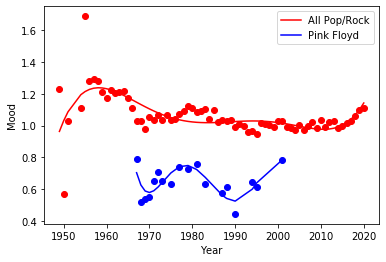

In [182]:
importancetoPR('Pink Floyd')